In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install mne
!pip install torch
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 10.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910459 sha256=d335845667113142b8b6ba00b4f086828a0e5d0db023d1bb721959aef2a1e676
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric


In [12]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import os.path as op
import mne
import json
import torch

data_path = '/content/drive/My Drive/ML/'


# Open the JSON file
with open(data_path + 'bigger.json', 'r') as file:
    # Load the JSON data
    loaded_data = json.load(file)


data = np.array(loaded_data['x'])
data = data.astype(float)

mean = np.mean(data, axis=0)
std = np.std(data, axis=0)

# Normalize the data by subtracting the mean and dividing by the standard deviation
normalized_data = (data - mean) / std

In [13]:
features_list = []
edge_index = []

for signal in normalized_data:
  df = pd.DataFrame(signal)
  df = df.apply(pd.to_numeric, errors='coerce')
  cor_matrix = df.corr()
  #Changes from dataframe to matrix, so it is easier to create a graph with networkx
  cor_matrix = np.asmatrix(cor_matrix)
  features = np.transpose(np.asarray(cor_matrix))
  features = np.transpose(features)
  features = torch.tensor(features)

  features_list.append(features)
  #Creates graph using the data of the correlation matrix
  G = nx.DiGraph(cor_matrix)
  edges = list(G.edges())
  # Return a sorted list of unique node names
  nodes_names = sorted(list(set([node for edge in edges for node in edge])))
  # Create a mapping between node names and indices
  node_dict = {node_name: index for index, node_name in enumerate(nodes_names)}
  # edge_index has dimensions of (2, num_edges)
  edge_index = torch.tensor([[node_dict[edge[0]], node_dict[edge[1]]] for edge in edges], dtype=torch.long).t().contiguous()

features_tensor = torch.stack(features_list)

In [14]:
import numpy as np
from scipy.signal import butter, filtfilt

# Define the filter parameters
low_freq = 1
high_freq = 50
sampling_rate = 250  # Assuming a sampling rate of 100 Hz

# Calculate the Nyquist frequency
nyquist_freq = 0.5 * sampling_rate

# Normalize the cutoff frequencies
normalized_low_freq = low_freq / nyquist_freq
normalized_high_freq = high_freq / nyquist_freq

# Define the filter order (adjust as needed)
filter_order = 2

# Compute the Butterworth filter coefficients
b, a = butter(filter_order, [normalized_low_freq, normalized_high_freq], btype='band')

# Apply the filter to each data sample
filtered_data = np.zeros_like(data)
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        filtered_data[i, j, :] = filtfilt(b, a, data[i, j, :])


filtered_data = np.nan_to_num(filtered_data, nan=0)
mean = np.mean(filtered_data, axis=0)
std = np.std(filtered_data, axis=0)

# Normalize the data by subtracting the mean and dividing by the standard deviation
filtered_data = (filtered_data - mean) / std

filtered_data_tensor = torch.tensor(filtered_data)
# filtered_data_tensor = filtered_data_tensor.view(288, -1)
filtered_data_tensor = filtered_data_tensor.permute(0, 2, 1)

In [15]:
filtered_data_tensor.shape

torch.Size([288, 22, 1001])

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

import torch.nn.functional as F

output_values = loaded_data['y']
output_values = [x - 1 for x in output_values]
n_classes = 4

labels = torch.tensor(output_values)

# Create one-hot encoding
one_hot = F.one_hot(labels, num_classes=n_classes)

In [18]:
from torch_geometric.nn import GCNConv, global_mean_pool, BatchNorm, global_add_pool

class EEGGraphConvNet(nn.Module):
    def __init__(self):
        super(EEGGraphConvNet, self).__init__()
        torch.manual_seed(42)

        self.conv1 = GCNConv(1001, 500, improved=True, cached=True, normalize=False)
        self.conv2 = GCNConv(500, 600, improved=True, cached=True, normalize=False)
        self.conv3_bn = BatchNorm(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

        self.fc_block1 = nn.Linear(600, 400)
        self.fc_block2 = nn.Linear(400,64)
        self.fc_block3 = nn.Linear(64, 4)

    def forward(self, x, edge_index, batch_index):
        x = F.leaky_relu(self.conv1(x, edge_index))
        x = F.leaky_relu(self.conv3_bn(self.conv2(x, edge_index)))
        out = global_add_pool(x, batch=batch_index)

        out = F.leaky_relu(self.fc_block1(out), negative_slope=0.01)
        out = F.dropout(out, p = 0.2, training=self.training)
        out = F.leaky_relu(self.fc_block2(out), negative_slope=0.01)
        out = F.dropout(out, p = 0.2, training=self.training)
        out = self.fc_block3(out)
        return out, x

model = EEGGraphConvNet()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

EEGGraphConvNet(
  (conv1): GCNConv(1001, 500)
  (conv2): GCNConv(500, 600)
  (conv3_bn): BatchNorm(600)
  (fc_block1): Linear(in_features=600, out_features=400, bias=True)
  (fc_block2): Linear(in_features=400, out_features=64, bias=True)
  (fc_block3): Linear(in_features=64, out_features=4, bias=True)
)
Number of parameters:  1069124


In [19]:
from torch_geometric.data import Data

input_list = []
for i in range(0, len(filtered_data_tensor)):
  input = Data(x=filtered_data_tensor[i], edge_index=edge_index, y=labels[i])
  input_list.append(input)


In [29]:
from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

# Root mean squared error
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-04)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[i*10 for i in range(1, 26)], gamma=0.1)


# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Wrap data in a data loader
data_size = len(input_list)
NUM_GRAPHS_PER_BATCH = 64
loader = DataLoader(input_list[:int(data_size * 0.8)],
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(input_list[int(data_size * 0.8):],
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)


In [30]:
from sklearn.model_selection import train_test_split

from joblib import load
import statistics as stats
from sklearn import preprocessing

import torch.backends.cudnn as cudnn
cudnn.enabled = True
cudnn.benchmark = False
cudnn.deterministic = True

from torch.utils.data import WeightedRandomSampler
from sklearn.metrics import make_scorer
from sklearn.metrics import balanced_accuracy_score, auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from torchvision.transforms import Compose, ToTensor
import sklearn.metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import random
from imblearn.over_sampling import SMOTE


accuracy_pts = []
validation_accuracy_pts = []
loss_pts = []
x_params = []

for epoch in range(200):

  model.train()
  train_loss = []
  val_loss = []

  y_probs_train = torch.empty(0, 4).to(device)

  y_true_train = [ ]
  y_pred_train = [ ]
  losses = 0.0
  for batch_idx, batch in enumerate(loader):

    X_batch = batch.to(device=device, non_blocking=True)
    y_batch = torch.tensor(batch.y)
    y_batch = y_batch.to(device=device, non_blocking=True)
    optimizer.zero_grad()
    outputs, embedding = model(X_batch.x.float(), X_batch.edge_index, X_batch.batch)
    loss = loss_fn(outputs, y_batch)
    losses += loss.item()
    train_loss.append(loss.item())
    loss.backward()

    _, predicted = torch.max(outputs.data, 1)
    y_pred_train += predicted.cpu().numpy().tolist()

    y_probs_train = torch.cat((y_probs_train, outputs.data), 0)
    y_true_train += y_batch.cpu().numpy().tolist()

    optimizer.step()
  scheduler.step()
  epoch_loss = losses / len(loader)
  loss_pts.append(epoch_loss)
  y_probs_train = torch.nn.functional.softmax(y_probs_train, dim=1).cpu().numpy()
  y_true_train = np.array(y_true_train)

  model.eval()
  with torch.no_grad():
    y_probs_val = torch.empty(0, 4).to(device)

    y_true_val = [ ]
    y_pred_val = [ ]

    for i, batch in enumerate(test_loader):
      X_batch = batch.to(device=device, non_blocking=True)
      y_batch = torch.tensor(batch.y)
      y_batch = y_batch.to(device=device, non_blocking=True)
      outputs, embedding = model(X_batch.x.float(), X_batch.edge_index, X_batch.batch)

      loss = loss_fn(outputs, y_batch)
      val_loss.append(loss.item())

      _, predicted = torch.max(outputs.data, 1)
      y_pred_val += predicted.cpu().numpy().tolist()

      y_probs_val = torch.cat((y_probs_val, outputs.data), 0)
      y_true_val += y_batch.cpu().numpy().tolist()

  y_probs_val = torch.nn.functional.softmax(y_probs_val, dim=1).cpu().numpy()
  y_true_val = np.array(y_true_val)

  print(f'Epoch: {epoch}---', end=" | ")
  print(f"Accuracy : {sklearn.metrics.accuracy_score(y_true_train, y_pred_train):.3f}, Loss: {loss_pts[-1]:.3f}", end=" | ")
  print(f"Validation Accuracy : {sklearn.metrics.accuracy_score(y_true_val, y_pred_val):.3f}")
  accuracy_pts.append(sklearn.metrics.accuracy_score(y_true_train, y_pred_train))
  validation_accuracy_pts.append(sklearn.metrics.accuracy_score(y_true_val, y_pred_val))
  x_params.append(epoch+1)



Epoch: 0--- | Accuracy : 0.891, Loss: 0.273 | Validation Accuracy : 0.603
Epoch: 1--- | Accuracy : 0.917, Loss: 0.237 | Validation Accuracy : 0.603
Epoch: 2--- | Accuracy : 0.930, Loss: 0.176 | Validation Accuracy : 0.569
Epoch: 3--- | Accuracy : 0.943, Loss: 0.141 | Validation Accuracy : 0.586
Epoch: 4--- | Accuracy : 0.930, Loss: 0.373 | Validation Accuracy : 0.586
Epoch: 5--- | Accuracy : 0.961, Loss: 0.100 | Validation Accuracy : 0.586
Epoch: 6--- | Accuracy : 0.948, Loss: 0.129 | Validation Accuracy : 0.586
Epoch: 7--- | Accuracy : 0.939, Loss: 0.236 | Validation Accuracy : 0.603
Epoch: 8--- | Accuracy : 0.965, Loss: 0.087 | Validation Accuracy : 0.603
Epoch: 9--- | Accuracy : 0.978, Loss: 0.101 | Validation Accuracy : 0.603
Epoch: 10--- | Accuracy : 0.965, Loss: 0.113 | Validation Accuracy : 0.603
Epoch: 11--- | Accuracy : 0.957, Loss: 0.157 | Validation Accuracy : 0.603
Epoch: 12--- | Accuracy : 0.983, Loss: 0.064 | Validation Accuracy : 0.603
Epoch: 13--- | Accuracy : 0.983, Lo

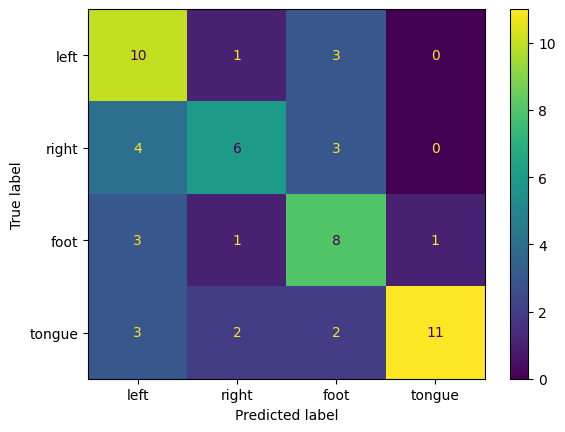

In [31]:
import matplotlib.pyplot as plt

confusion_matrix = sklearn.metrics.confusion_matrix(y_true_val, y_pred_val)
cm_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["left", "right", "foot", "tongue"])
# plt.rcParams["figure.figsize"] = (20,3)
cm_display.plot()
plt.axis('tight')
plt.show()